In [1]:
!which python

/Users/pushkalm11/miniconda3/envs/unrolling/bin/python


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.linalg import matrix_power as MP

In [3]:
import random
import scipy
from scipy.spatial.distance import cdist
from scipy.io import savemat, loadmat
from scipy.optimize import Bounds

In [4]:
import networkx as nx
import sys

In [5]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [6]:
print(f"TF Version: {tf.__version__}")

TF Version: 2.14.0


In [7]:
X_train = loadmat('./Dataset/X_train.mat')['X_Ground']
Adj_train = loadmat('./Dataset/Adj.mat')['A_Ground']

N, T = X_train.shape

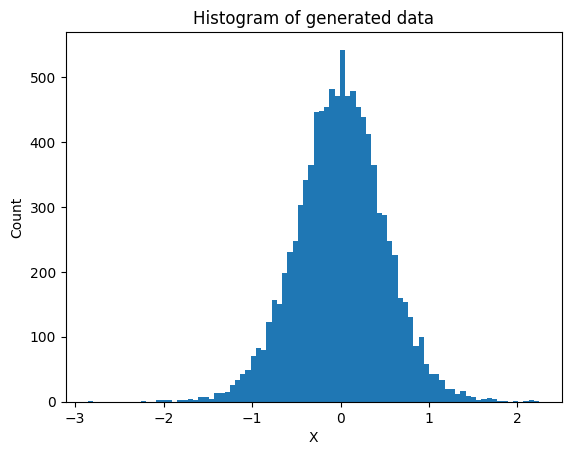

In [8]:
plt.hist(np.array(X_train).flatten(), bins = 'auto')
plt.xlabel("X")
plt.ylabel("Count")
plt.title("Histogram of generated data")
plt.show()

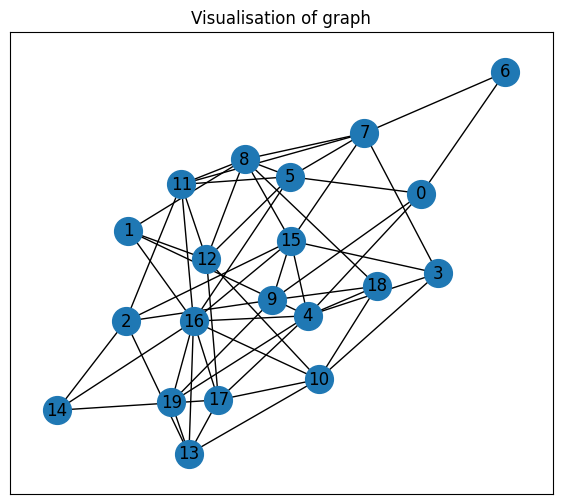

In [9]:
fig = plt.figure(figsize = (7, 6))
rows, cols = np.where(Adj_train == 1)
edges = zip(rows.tolist(), cols.tolist())

gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw_networkx(gr, node_size = 400)

plt.title("Visualisation of graph")
plt.show()

In [10]:
print(N, T)

20 500


In [11]:
dt = np.zeros([T - 1, T])

for i in range(T - 1):
    dt[i, i] = -1
    dt[i, i - 1] = 1

d = dt.T
d = np.concatenate((d, np.zeros([T, 1])), axis = 1) 
d[T - 1, T - 1] = -1
d = d.T
d[T - 1, T - 1] = 1 
d[-1, -2] = 1
d[0, -1] = 0

d = tf.convert_to_tensor(d, dtype = "float32")

print(d)

tf.Tensor(
[[-1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1.  1.]], shape=(500, 500), dtype=float32)


In [12]:
Mul = np.eye(N) - np.ones([N, N])
Mul = tf.convert_to_tensor(Mul, dtype = "float32")

In [13]:
def initial_graph(X_training, N):
    distance_matrix = cdist(X_training, X_training, metric = 'euclidean')
    
    top_values = 6
    sorted_indices = distance_matrix.argsort(1)
    TAdj = np.zeros([N, N])
    
    for i in range(N):
        for j in range(1, top_values):
            k = sorted_indices[i][j]
            TAdj[i][k] = 1
    
    TAdj = (TAdj + TAdj.T) / 2
    TAdj = np.where(TAdj > 0.1, 1, 0)
    
    Laplacian_init = np.diag(np.sum(TAdj, 1)) - TAdj
    
    return Laplacian_init

In [14]:
psi_cost = 0
Laplacian = 0
A_transform_cost = 0

In [15]:
# A - Predicted, B - Target matrix
def costfunc(A, B):
    global psi_cost
    global Laplacian
    global A_transform_cost

    B_tmp = tf.squeeze(B)
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (A - B))) ** 2)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    L_cost = (tf.norm(Laplacian) ** 2)
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (smoothness) + (data_fidelity) + (L_cost) + (Z_cost)
    
def costfunc1(A, B):
    global psi_cost
    
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (A - B))) ** 2)
    return (data_fidelity)

def costfunc2(A, B):
    global Laplacian
    global A_transform_cost
    
    B_tmp = tf.squeeze(B)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    
    return (smoothness)

def costfunc3(A, B):
    global Laplacian
    
    L_cost = (tf.norm(Laplacian) ** 2)
    
    return (L_cost)

def costfunc4(A, B):
    global A_transform_cost
    
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (Z_cost)

In [16]:
def forward_pass(X_train_concatenated, params, p1, p2, d):
    
    def data_inpainting(loop_b, reg, psi, Y, Lk, AAT):

        Xk = tf.zeros_like(Y)
        Zk = -(tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT)))

        for i in range(loop_b):
            fdx_xk = tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT))
            fdx_zk = tf.multiply(psi, Zk) - Y + (2 * reg * (Lk @ Zk @ AAT))

            tau = tf.linalg.trace(tf.transpose(fdx_xk) @ Zk) / tf.linalg.trace(tf.transpose((Y + fdx_zk)) @ Zk)
            
            Xk_1 = Xk - (tau * Zk)

            fdx_xk_1 = tf.multiply(psi, Xk_1) - Y + (2 * reg * (Lk @ Xk_1 @ AAT))
            gamma = (tf.norm(fdx_xk_1) ** 2) / (tf.norm(fdx_xk) ** 2)

            Zk_1 = (gamma * Zk) - fdx_xk_1

            Xk = Xk_1
            Zk = Zk_1
        
        return Xk_1
    
    def graph_learning(loop_c, alpha, beta, X, Lk, AAT):
        
        X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
        
        for i in range(loop_c):
            fdL_Lk = X_AAT_XT + (beta * Lk)

            fdL_Lk = fdL_Lk - tf.reshape(tf.reduce_mean(fdL_Lk, 1), [N, 1])
            fdL_Lk = (fdL_Lk + tf.transpose(fdL_Lk)) / 2
            
            Lk_1 = Lk - (alpha * fdL_Lk)
            
            Adj_k1 = tf.multiply(Mul, Lk_1)
            Adj_k1 = tf.nn.relu(Adj_k1)
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj_k1, 1)) - Adj_k1
            
            Lk = Lk_1
            
        return Lk
    
    # def graph_learning(loop_c, alpha, beta, X, Lk, AAT):
        
    #     # Computing the smoothness term
    #     X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
        
    #     for i in range(loop_c):

    #         # Extracting the adjacency matrix from the Laplacian
    #         adj_i = tf.multiply(Mul, Lk)

    #         # Computing the gradient with respect to laplacian
    #         fdL_Lk = X_AAT_XT + (beta * Lk)
            
    #         # Extracting the adjacency matrix from the gradient
    #         adj_grad = tf.multiply(Mul, fdL_Lk)
            
    #         # Computing the new adjacency
    #         adj_i1 = adj_i - (alpha * adj_grad)
            
    #         # Avoiding any negative values
    #         adj_i1 = tf.nn.relu(adj_i1)

    #         # Computing the new laplacian
    #         Lk_1 = tf.linalg.diag(tf.math.reduce_sum(adj_i1, 1)) - adj_i1
            
    #         # Updating the laplacian
    #         Lk = Lk_1
            
    #     return Lk
    
    y = X_train_concatenated
    
    psi = y[0,:,T:]
    global psi_cost
    psi_cost = psi

    psi = tf.convert_to_tensor(psi, dtype = "float32")

    X_in = y[0,:,:T]
    X_in = psi * tf.convert_to_tensor(X_in, dtype = "float32")
    Y = X_in
    
#     global X_train
#     X_train = X_in
    
    loop_a, loop_b, loop_c, reg, alpha, beta, threshold, Lk = params
    
    LT = tf.matmul(d, tf.transpose(d))
    LT = tf.convert_to_tensor(LT, dtype = "float32")
    
    A_transform = tf.eye(T) + (p1 * MP(LT, 1)) + (p2 * MP(LT, 2))
    AAT = A_transform
    
    global A_transform_cost
    A_transform_cost = AAT
    
    for i in range(loop_a):
            
        Xk_1 = data_inpainting(loop_b, reg, psi, Y, Lk, AAT)

        Xk_1_gt = X_in + tf.multiply((tf.ones(psi.shape) - psi), Xk_1)

        Lk_1 = graph_learning(loop_c, alpha, beta, Xk_1_gt, Lk, AAT)

        Adj = tf.linalg.diag(tf.linalg.diag_part(Lk_1)) - Lk_1

        n = tf.math.count_nonzero(Adj, dtype="float32")
        mean = tf.math.reduce_sum(Adj) / n
        Adj = tf.math.subtract(Adj, (threshold * mean))

        Adj = tf.nn.relu(Adj)
        # Adj = tf.math.sign(Adj)

        Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj, 1)) - Adj

        Lk = Lk_1
        
        global Laplacian
        Laplacian = Lk
    
    Xk = data_inpainting(loop_b, reg, psi, Y, Lk, AAT)
    tmp = np.array([costfunc1(X_train, Xk), costfunc2(X_train, Xk), 
                    costfunc3(X_train, Xk), costfunc4(X_train, Xk)])

    return tmp

In [17]:
def optimize_this(coeffs):
    
    c1 = np.array(coeffs) * c1_test
    c1_del = np.array(coeffs) * c1_del_test
    c2_del = np.array(coeffs) * c2_del_test

#     return ((np.sum(c1_del - c1) / delta) ** 2) + ((np.sum(c2_del - c1) / delta) ** 2)
    return np.abs(np.sum(c1_del - c1) / delta) + np.abs(np.sum(c2_del - c1) / delta)

In [18]:
no_of_psi = 1
sensing_ratio = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]
# sensing_ratio = (1 + np.arange(80)) / 100

all_psi = []
opt_coeffs = []

p1, p2 = 8.0 / 2.0, 10.0 / 6.0

loop_a = 5
loop_b = 10 
loop_c = 10 
reg_init = 5.0e-5
alpha_init = 0.05
beta_init = 0.1
# alpha_init = 1.0e-3
# beta_init = 1.0e1
threshold_init = 0.3
Lap_init = initial_graph(X_train, N)

params = [loop_a, loop_b, loop_c, reg_init, alpha_init, beta_init, threshold_init, Lap_init]

delta = 1e-2

In [19]:
guess_params = np.abs(np.random.rand(4))
bound = (1e-12, None)

for i, sr in enumerate(sensing_ratio):
    
    M = int(sr * T)
    X_train_missing = np.zeros([no_of_psi, N, T])
    X_train_concatenated = np.zeros([no_of_psi, N, 2 * T])

    for i in range(no_of_psi):
        psi_k = np.array([0] * (N * M) + [1] * (N * (T - M)))
        np.random.shuffle(psi_k)
        psi_k = psi_k.reshape([N, T])
        all_psi.append(psi_k)
        X_train_missing[i, : , : ] = X_train * psi_k
        X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)

    Laplacian = 0
    
    c1_test = forward_pass(X_train_concatenated, params, p1, p2, d)
    c1_del_test = forward_pass(X_train_concatenated, params, p1 + delta, p2, d)
    c2_del_test = forward_pass(X_train_concatenated, params, p1, p2 + delta, d)
    
    mul = 10 ** (-np.floor(np.log10(c1_test), dtype = "float"))
    guess_params = mul
    print(mul)
    
    opt_val = scipy.optimize.minimize(optimize_this, np.abs(np.random.rand(4)), 
                                      bounds = [bound, bound, bound, bound])
    
    # opt_coeffs.append(np.array(opt_val.x))
    
    opt_coeffs.append(np.array(mul))
    print(f"Sensing Ratio: {int(100 * sr)}%")
    print(f"The optimal coefficients are:", list(opt_coeffs[-1]), f"\n")

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 1%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 2%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 3%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 4%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 5%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 6%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 7%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 8%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing Ratio: 9%
The optimal coefficients are: [0.1, 1e-06, 1e-06, 1e-05] 

[1.e-01 1.e-06 1.e-06 1.e-05]
Sensing

In [20]:
opt_coeffs

[array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.e-05]),
 array([1.e-01, 1.e-06, 1.e-06, 1.

In [21]:
np.save("./Outputs/cost_func_coeffs.npy", opt_coeffs)

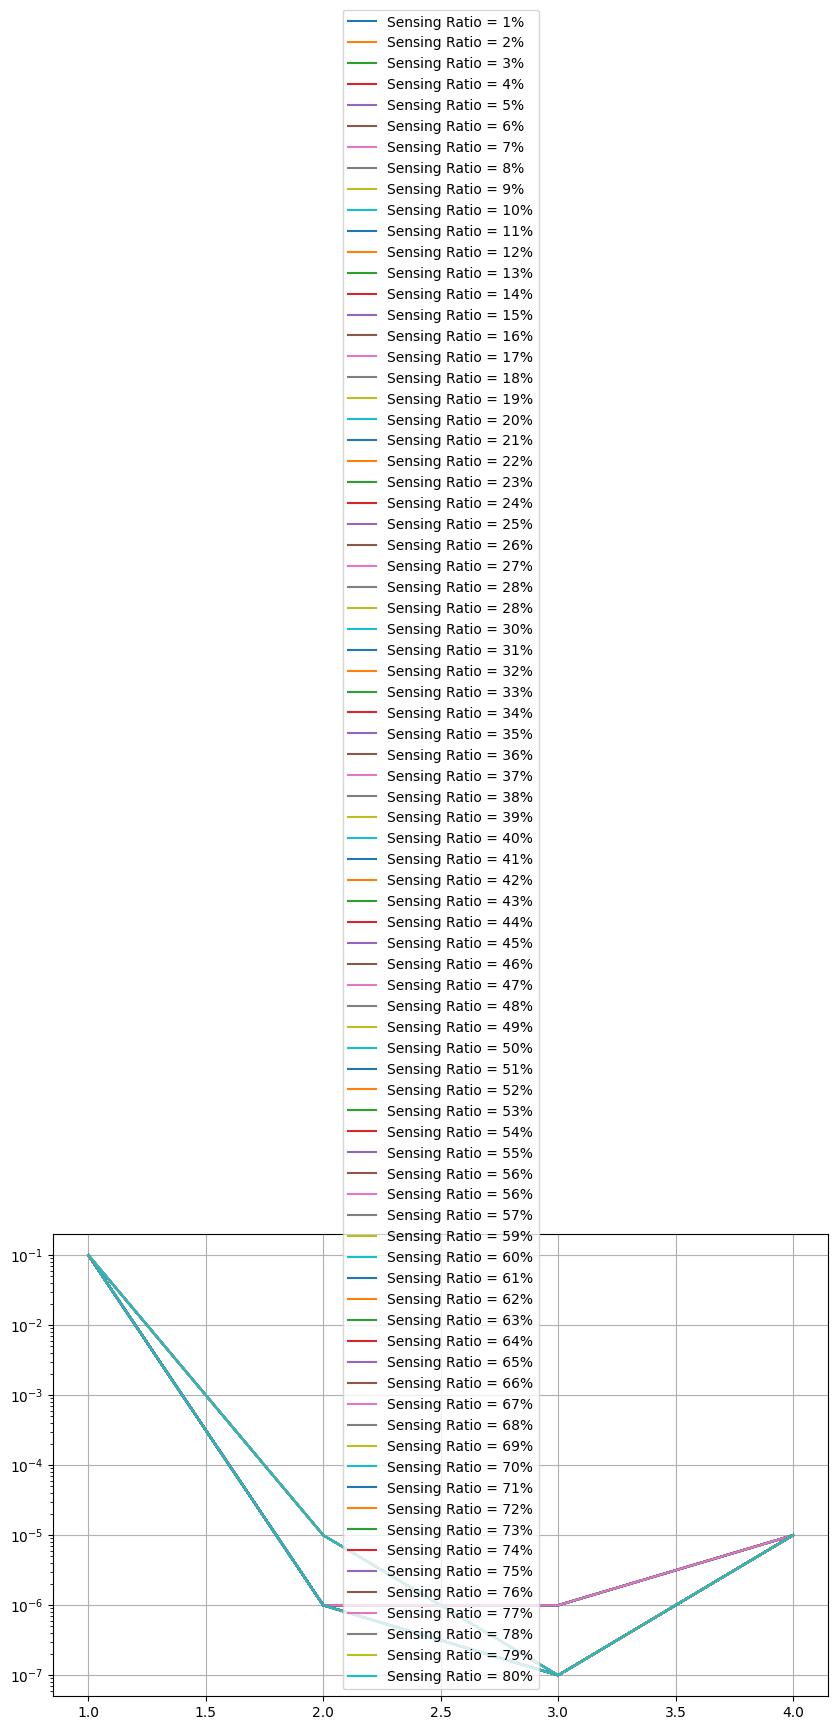

In [22]:
fig = plt.figure(figsize = [10, 6])

for i in range(len(opt_coeffs)):
    plt.plot(1 + np.arange(4), opt_coeffs[i], label = f"Sensing Ratio = {int(100 * sensing_ratio[i])}%")

plt.yscale("log")
plt.legend()
plt.grid()
plt.show()